# Q2

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# Load the Oxford-IIIT Pet dataset
dataset_name = "oxford_iiit_pet"
(ds_train_val, ds_test), ds_info = tfds.load(name=dataset_name, split=['train', 'test'], with_info=True, as_supervised=True)

# Define the size of the dataset
total_train_samples = ds_info.splits['train'].num_examples
total_test_samples = ds_info.splits['test'].num_examples

# Reserve 20% for validation from total_train_samples
train_size = int(0.8 * total_train_samples)
val_size = int(0.2 * total_train_samples)

# Split the dataset into train, validation
ds_train = ds_train_val.take(train_size)
ds_val = ds_train_val.skip(train_size).take(val_size)

print(f"Number of training samples: {ds_train.cardinality()}")
print(f"Number of validation samples: {ds_val.cardinality()}")
print(f"Number of test samples: {ds_test.cardinality()}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteSAGZOJ/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteSAGZOJ/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
Number of training samples: 2944
Number of validation samples: 736
Number of test samples: 3669


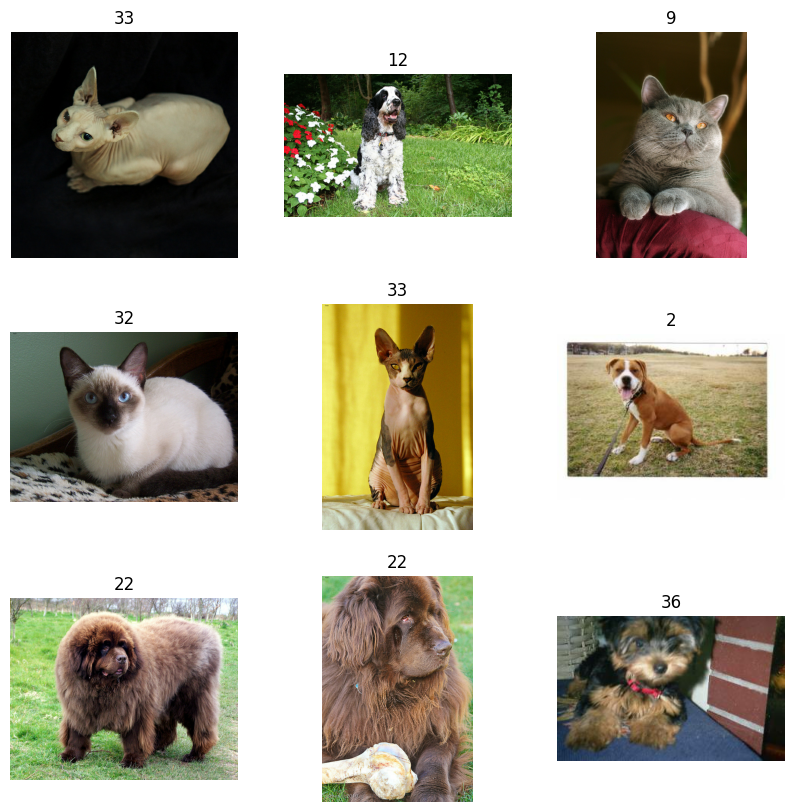

In [ ]:
#plot first 9 images in the training dataset with labels
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [ ]:
#resize images to 150x150
resize_fn = tf.keras.layers.Resizing(150, 150)
ds_train = ds_train.map(lambda x, y: (resize_fn(x), y))
ds_val = ds_val.map(lambda x, y: (resize_fn(x), y))
ds_test = ds_test.map(lambda x, y: (resize_fn(x), y))

In [ ]:
#Using random data augmentation
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]
def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x
ds_train = ds_train.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
from tensorflow import data as tf_data
batch_size = 64
ds_train = ds_train.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
ds_val = ds_val.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
ds_test = ds_test.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

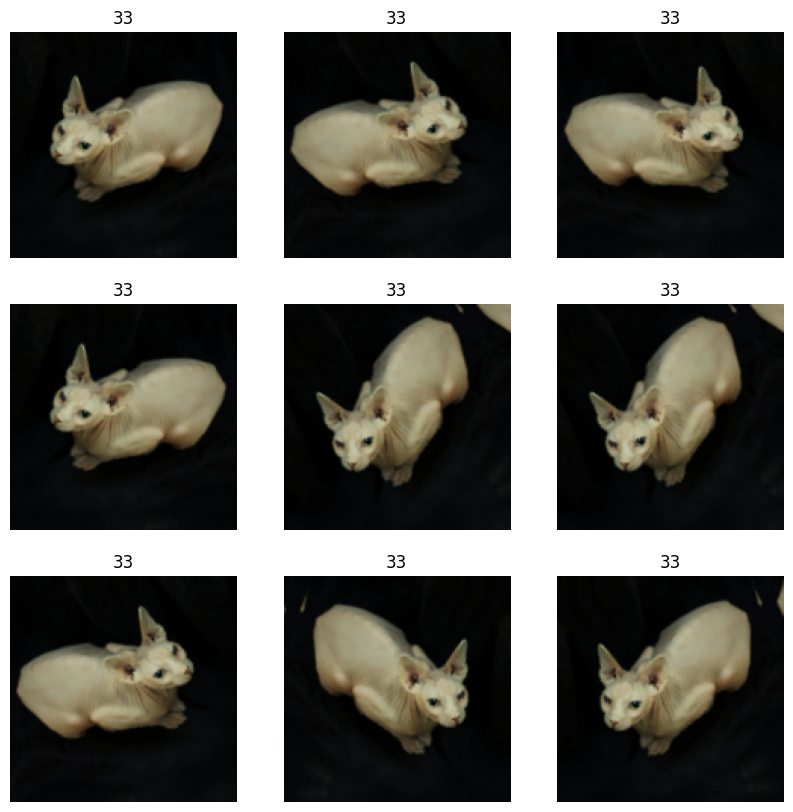

In [ ]:
import numpy as np
for images, labels in ds_train.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = tf.keras.applications.DenseNet201(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(37, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary(show_trainable=True)

74836368/74836368 [==============================] - 3s 0us/step
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 densenet201 (Functional)    (None, 4, 4, 1920)        1832198   N          
                                                       4                    
                                                                            
 global_average_pooling2d (  (None, 1920)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                         

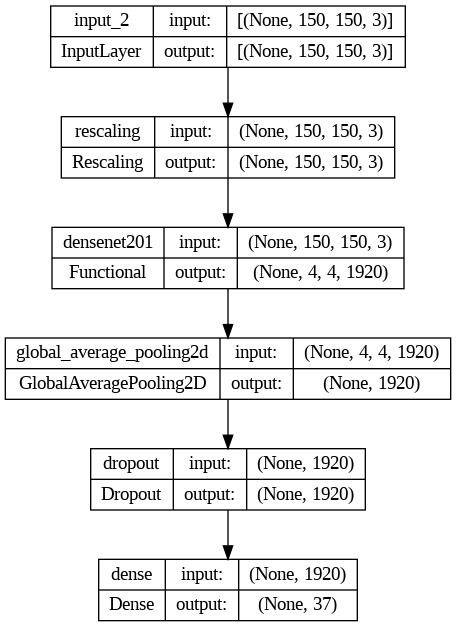

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model
initial_epochs = 2
history = model.fit(
    ds_train,
    epochs=initial_epochs,
    validation_data=ds_val
)

Epoch 1/2
46/46 [==============================] - 64s 780ms/step - loss: 2.5136 - accuracy: 0.3621 - val_loss: 0.7895 - val_accuracy: 0.7514
Epoch 2/2
46/46 [==============================] - 8s 170ms/step - loss: 0.8418 - accuracy: 0.7374 - val_loss: 0.5613 - val_accuracy: 0.8370


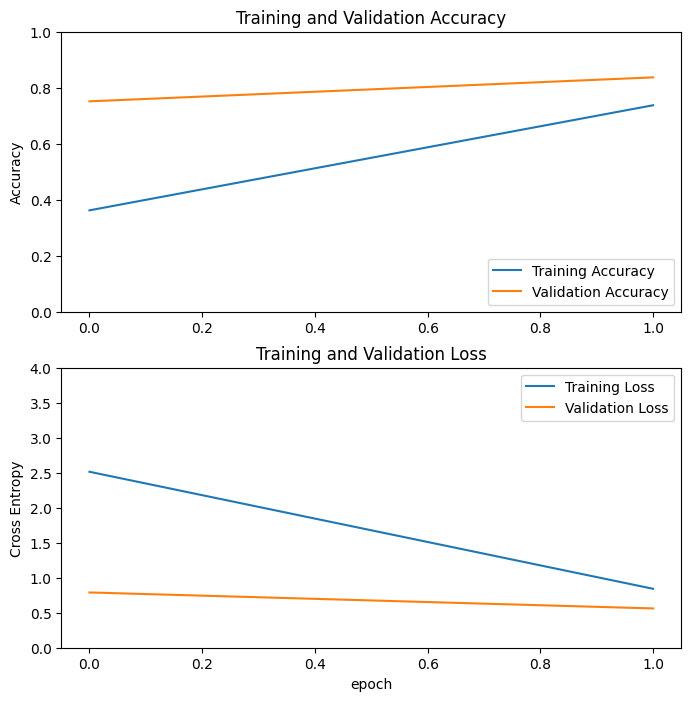

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(ds_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

58/58 [==============================] - 15s 261ms/step - loss: 0.5825 - accuracy: 0.8190
Test Accuracy: 81.90%


In [ ]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 densenet201 (Functional)    (None, 4, 4, 1920)        1832198   Y          
                                                       4                    
                                                                            
 global_average_pooling2d (  (None, 1920)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1920)              0     

In [ ]:
# Train the model
fine_tune_epochs = 13  #  number of epochs
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(
    ds_train,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=ds_val
)

Epoch 2/15
46/46 [==============================] - 25s 543ms/step - loss: 0.0079 - accuracy: 0.9983 - val_loss: 0.5413 - val_accuracy: 0.8723
Epoch 3/15
46/46 [==============================] - 25s 550ms/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 0.5220 - val_accuracy: 0.8927
Epoch 4/15
46/46 [==============================] - 25s 545ms/step - loss: 0.0040 - accuracy: 0.9986 - val_loss: 0.5902 - val_accuracy: 0.8899
Epoch 5/15
46/46 [==============================] - 26s 560ms/step - loss: 0.0067 - accuracy: 0.9990 - val_loss: 0.4977 - val_accuracy: 0.8954
Epoch 6/15
46/46 [==============================] - 25s 545ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 0.4876 - val_accuracy: 0.8954
Epoch 7/15
46/46 [==============================] - 25s 549ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.5089 - val_accuracy: 0.8845
Epoch 8/15
46/46 [==============================] - 25s 546ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.5226 - val_accuracy: 0.8913

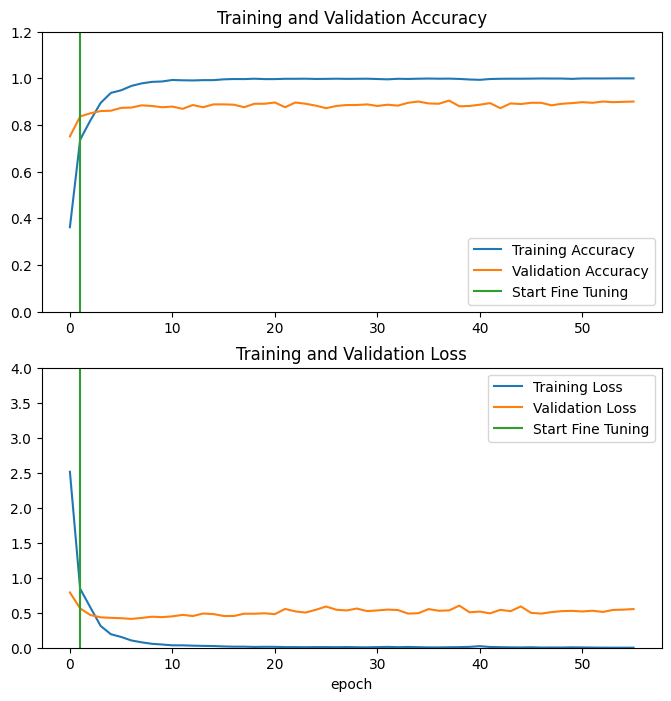

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.2])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(ds_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

58/58 [==============================] - 8s 137ms/step - loss: 0.6845 - accuracy: 0.8678
Test Accuracy: 86.78%
